In [1]:
import os
from os import listdir
from os.path import join
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt

In [2]:
def split_data(dir):

    idx_dict = {
        'train': [
            34, 101, 114, 82, 123, 57, 22, 15, 137, 83, 99, 72, 47,
            36, 96, 46, 120, 60, 19, 79, 58, 134, 39, 102, 126, 94,
            7, 106, 2, 40, 70, 52, 104, 12, 119, 76, 108, 90, 147,
            143, 43, 140, 142, 88, 93, 4, 51, 16, 121, 74, 64, 77,
            98, 107, 56, 13, 92, 3, 141, 136, 146, 78, 91, 35, 124,
            63, 130, 84, 17, 80, 25, 118, 6, 113, 117, 67, 100, 54,
            103, 95, 37, 23, 32, 30, 42, 144, 75, 38, 50, 31, 66,
            131, 68, 97, 85, 44, 69, 33, 5, 138, 49, 14, 128, 24,
            11, 89, 135, 10, 29, 116, 65, 18, 125, 20, 26, 111, 73,
            48, 59, 139],
        'validation': [86, 21, 55, 61, 45, 81, 105, 149, 27, 132, 28, 129, 1, 53, 133],
        'test': [115, 109, 87, 112, 8, 9, 122, 41, 148, 110, 145, 71, 150, 127, 0, 62]
    }

    image_dir = dir + '/images'
    mask_dir = dir +'/masks'

    image_names = sorted([image for image in listdir(image_dir) if image.endswith('.png')])
    
    train_names = [image_names[idx] for idx in idx_dict['train']]
    validation_names = [image_names[idx] for idx in idx_dict['validation']]
    test_names = [image_names[idx] for idx in idx_dict['test']]

    name_dict = {'train': train_names, 'validation': validation_names, 'test': test_names}

    return name_dict

In [3]:
def get_slice_idxs(size, down_size):
    height, width = size[:2]
    down_height, down_width = down_size[:2]

    n_images_height = height // down_height + 1
    n_images_width = width // down_width + 1

    offsets_height = np.concatenate(([0], np.diff(np.linspace(0,  n_images_height * down_height - height, n_images_height, dtype=int))))
    offsets_height = np.cumsum(offsets_height).reshape(-1, 1)
    offsets_width = np.concatenate(([0], np.diff(np.linspace(0,  n_images_width * down_width - width, n_images_width, dtype=int))))
    offsets_width = np.cumsum(offsets_width).reshape(-1, 1)

    idxs_height = np.arange(0, n_images_height)
    idxs_height = np.concatenate((idxs_height, idxs_height+1))*down_height
    idxs_height = idxs_height.reshape(-1, 2, order='F') - offsets_height

    idxs_width = np.arange(0, n_images_width)
    idxs_width = np.concatenate((idxs_width, idxs_width+1))*down_width
    idxs_width = idxs_width.reshape(-1, 2, order='F') - offsets_width

    return idxs_height, idxs_width

def slice_image(image, size, idxs_height, idxs_width):
    images = torch.empty((len(idxs_height), len(idxs_width), *size))
    for i, (sy, ey) in enumerate(idxs_height):
        for j, (sx, ex) in enumerate(idxs_width):
            images[i, j] = image[sy:ey, sx:ex]
    return images

def unslice_images(images, size, idxs_height, idxs_width, combine_func=lambda x: torch.mean(x, axis=0)):
    image = torch.full((size), torch.nan)
    for i, (sy, ey) in enumerate(idxs_height):
        for j, (sx, ex) in enumerate(idxs_width):
            slice = image[sy:ey, sx:ex]
            slice[torch.isnan(slice)] = images[i, j, torch.isnan(slice)]
            slice[~torch.isnan(slice)] = combine_func((slice[~torch.isnan(slice)], images[i, j, ~torch.isnan(slice)]), axis=0)        
    return image

# unslice_images(slices, image.shape, idxs_height, idxs_width)

In [4]:
raw_dir = '../data/raw'
name_dict = split_data(raw_dir)

In [5]:
from tqdm import tqdm
from torch.nn.functional import one_hot
masks_paths = [raw_dir + "/masks/" + name for name in listdir(raw_dir + "/masks") if name.endswith('.png')]
images_paths = [raw_dir + "/images/" + name for name in listdir(raw_dir + "/masks") if name.endswith('.png')]

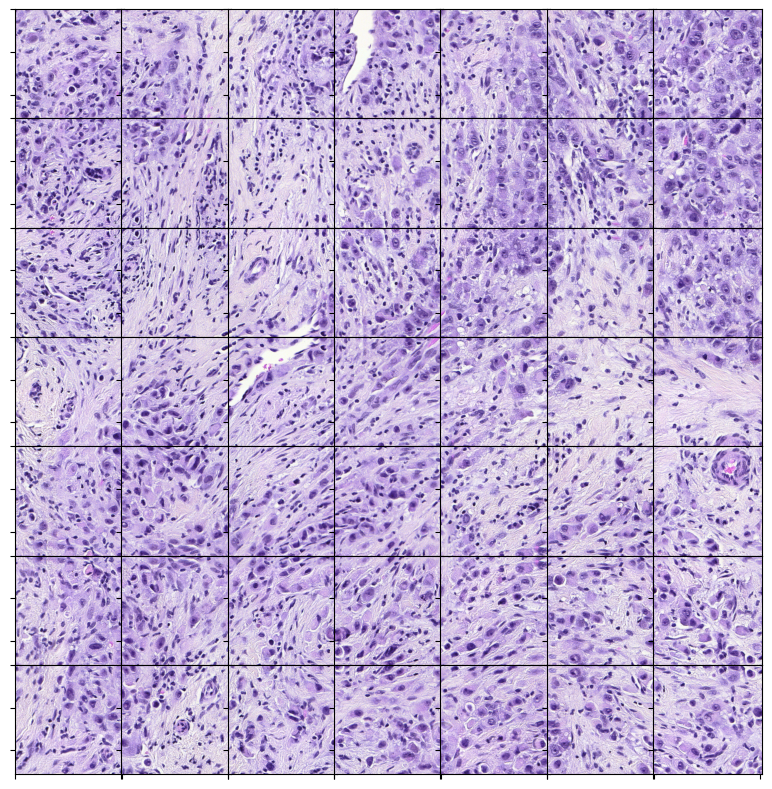

In [ ]:
fig, ax = plt.subplots(7,7,figsize=(12,8))

for i in range(7):
    for j in range(7):
        ax[i,j].imshow(slices[i,j])
        ax[i,j].set_xticklabels([])
        ax[i,j].set_yticklabels([])
        ax[i,j].set_aspect('equal')

plt.tight_layout()
plt.subplots_adjust(wspace=-.8, hspace=0)

In [11]:
from functools import partial
from p_tqdm import p_map

def save_slices(key, idx, image_slices, mask_slices):
    for i in range(image_slices.shape[0]):
        for j in range(image_slices.shape[1]):
            name = f'{key}_{idx}_{i}_{j}.pt'
            torch.save((image_slices[i,j].clone(), mask_slices[i,j].clone()), f'../data/processed/{key}/{name}')

def slice_and_save(idx, name, key, raw_dir, num_classes):
    image_path = os.path.join(raw_dir, "images", name)
    mask_path = os.path.join(raw_dir, "masks", name)

    image = torch.moveaxis(torchvision.io.read_image(image_path), 0, -1)
    idxs_height, idxs_width = get_slice_idxs(image.shape, (512, 512))

    image_slices = slice_image(image, (512, 512, 3), idxs_height, idxs_width).to(torch.uint8)
    image_slices = torch.moveaxis(image_slices, -1, 2)

    mask = torchvision.io.read_image(mask_path)[0].to(torch.int64)
    mask[mask > 4] = 5
    onehot = F.one_hot(mask, num_classes = num_classes)

    mask_slices = slice_image(onehot, (512, 512, 6), idxs_height, idxs_width).to(torch.bool)
    mask_slices = torch.moveaxis(mask_slices, -1, 2)

    save_slices(key, idx, image_slices, mask_slices)


def process_and_save_data(key, raw_dir, name_dict, one_hot=True):
    folder = f'../data/processed/{key}'

    if not os.path.exists(folder):
        os.makedirs(folder)

    num_classes = 6

    func = partial(slice_and_save, key=key, raw_dir=raw_dir, num_classes=num_classes)

    p_map(func, list(range(len(name_dict[key]))), name_dict[key])
    #for idx, name in tqdm(enumerate(name_dict[key])):
    #    (idx, name)
    #    break

In [12]:
raw_dir = '../data/raw'
name_dict = split_data(raw_dir)

for key in ['train', 'validation', 'test']:
    process_and_save_data(key, raw_dir, name_dict)
    break

  0%|          | 0/120 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [156]:
a = torch.load("../data/processed/train/train_0_2_1.pt")

In [184]:
np.save("test.npy", a[1].numpy())

In [185]:
torch.save(a[1].clone(), "tensor.pt")

In [167]:
b = torch.ones((36, 3, 512, 512), dtype=torch.uint8)

In [14]:
mask_dir = sorted([image for image in listdir(raw_dir+'/masks/') if image.endswith('.png')])

for name in mask_dir:
    print(nn.unique(torchvision.io.read_image(raw_dir+'/masks/'+name)))

tensor([1, 2, 3, 4, 9], dtype=torch.uint8)
tensor([ 1,  2,  3,  4,  5, 13, 18], dtype=torch.uint8)
tensor([ 1,  2,  3,  4, 13, 18], dtype=torch.uint8)
tensor([1, 2, 3, 7], dtype=torch.uint8)
tensor([ 1,  2,  3,  4,  7, 18], dtype=torch.uint8)
tensor([ 1,  2,  3,  4, 18], dtype=torch.uint8)
tensor([ 1,  2,  3,  4,  6,  7, 10, 13, 18], dtype=torch.uint8)
tensor([1, 2, 4, 7], dtype=torch.uint8)
tensor([ 1,  2,  3, 18], dtype=torch.uint8)
tensor([ 1,  2,  3,  6,  7,  9, 18], dtype=torch.uint8)
tensor([1, 2, 3, 4, 7], dtype=torch.uint8)
tensor([ 1,  2,  3,  4, 13, 18], dtype=torch.uint8)
tensor([ 0,  1,  2,  3, 13, 18], dtype=torch.uint8)
tensor([ 1,  2,  3,  4,  7, 15], dtype=torch.uint8)
tensor([ 1,  2,  3,  5, 13, 18], dtype=torch.uint8)
tensor([ 1,  2,  3,  7, 18, 19], dtype=torch.uint8)
tensor([ 1,  2,  3,  7, 15], dtype=torch.uint8)
tensor([ 1,  2,  6, 18], dtype=torch.uint8)
tensor([ 1,  2,  3,  4, 10], dtype=torch.uint8)
tensor([ 1,  2,  3,  4,  5,  6,  9, 15, 18], dtype=torch.uint8